In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import pyramid
import math
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import requests
from io import BytesIO
from sklearn import metrics
import pandas as pd
from pyramid.arima import auto_arima

np.random.seed(123)

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [2]:
def f_1(time):
    """
    time: np.array (len_ts,)
    """
    return time.reshape(-1,1)

def f_2(time):
    noise = np.random.randn(time.shape[0])
    f = lambda t: t * np.sin(t) + 200
    vfunc = np.vectorize(f)
    f_time = vfunc(time)
    return (f_time+noise).reshape(-1,1)

def f_3(time, period):
    f = lambda t: 100 * np.sin(t // period) + 100 + 2*t
    vfunc = np.vectorize(f)
    f_time = vfunc(time)
    return f_time.reshape(-1,1)

def f_4(time, period):
    f = lambda t: 100 * np.cos(t // period) + 100 + 2*t
    vfunc = np.vectorize(f)
    f_time = vfunc(time)
    return f_time.reshape(-1,1)

def generate_ts_1(exog):
    """
    exog: np.array (len_ts, k_exog)
    """
    a = (np.ones(exog.shape[1])/exog.shape[1]).reshape(-1,1)
    y = exog @ a
    return y

def generate_ts_2(exog):
    y = np.zeros(exog.shape[0])
    a = (np.ones(exog.shape[1])/exog.shape[1]).reshape(-1,1)
    for i in range(exog.shape[0]):
        y[i] = exog[i] @ a
        if (y[i-1] != None):
            y[i] = y[i] + 0.3 * y[i-1]
        if (y[i-2] != None):
            y[i] = y[i] + 0.2 * y[i-2]
        if (y[i-3] != None):
            y[i] = y[i] + 0.1 * y[i-3]
    return y

def generate_redundant_exog(time):
    n = time.shape[0]
    e = 100 * np.fabs(np.random.randn(n)).reshape(-1,1)
    return e

In [3]:
Time = np.arange(0,200)

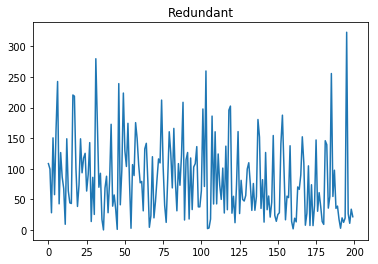

In [4]:
plt.plot(Time,generate_redundant_exog(Time))
plt.title("Redundant")
plt.show()

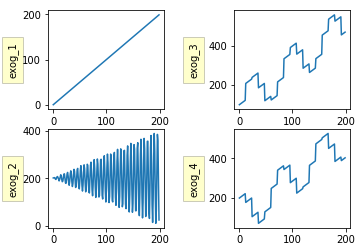

In [5]:
box = dict(facecolor='yellow', pad=5, alpha=0.2)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)

# Fixing random state for reproducibility
np.random.seed(19680801)

ax1.plot(Time,f_1(Time))
ax1.set_ylabel('exog_1', bbox=box)


ax3.set_ylabel('exog_2',bbox=box)
ax3.plot(Time,f_2(Time))

labelx = -0.3  # axes coords

ax2.plot(Time,f_3(Time,period=12))
ax2.set_ylabel('exog_3', bbox=box)
ax2.yaxis.set_label_coords(labelx, 0.5)


ax4.plot(Time,f_4(Time, period=12))
ax4.set_ylabel('exog_4', bbox=box)
ax4.yaxis.set_label_coords(labelx, 0.5)

plt.show()

In [6]:
Exog_first = np.concatenate([f_1(Time),f_2(Time),f_3(Time, period=12),f_4(Time, period=12)], axis =1)
print (Exog_first.shape)

(200, 4)


In [7]:
y_1 = generate_ts_1(Exog_first)
y_2 = generate_ts_2(Exog_first)
Exog = np.concatenate([Exog_first, generate_redundant_exog(Time)], axis = 1)
Exog.shape

(200, 5)

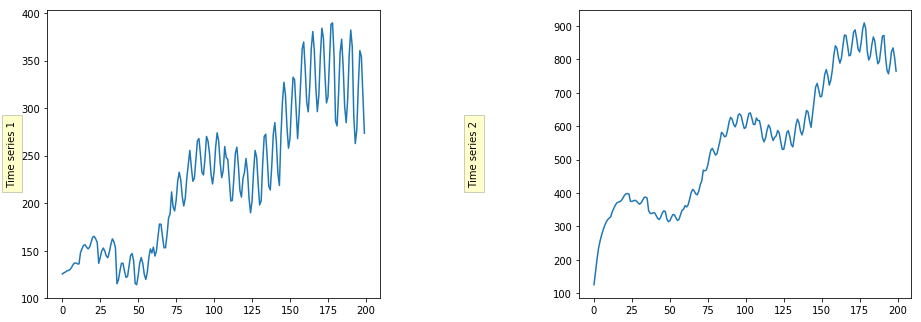

In [8]:
box = dict(facecolor='yellow', pad=5, alpha=0.2)

fig, ((ax1, ax2)) = plt.subplots(1, 2,)
fig.subplots_adjust(top=2, bottom=1,  right=2, left=0, wspace=0.6)

ax1.plot(Time,y_1)
ax1.set_ylabel('Time series 1', bbox=box)


ax2.plot(Time,y_2)
ax2.set_ylabel('Time series 2', bbox=box)
ax2.yaxis.set_label_coords(labelx, 0.5)


plt.show()

In [9]:
def plot_results(clue,y,forecast):
    plt.figure(figsize=(10,7))
    l1 = plt.plot(Time,y,label = 'observed')
    l2 = plt.plot(Time, forecast, label = 'forecasted')
    observed_test = y[100:]
    forecast_test = forecast[100:]
    plt.title("df{}: MAPE = {}, MAE ={}".format(clue,mean_absolute_percentage_error(observed_test.squeeze(),
                                                                                    forecast_test.squeeze()),
                                               mean_absolute_error(observed_test,forecast_test)))
    plt.axvline(x=100, color = 'red')
    plt.legend()
    plt.grid()
    plt.show()

In [10]:
train_data_1 = y_1[:100]
test_data_1 = y_1[100:]
train_data_2 = y_2[:100]
test_data_2 = y_2[100:]
exog_train = Exog[:100]
exog_test = Exog[100:]

In [11]:
def pyramid_stepwise(train_data=None, Exog_train=None, Exog_test=None,exog_flag = False, period = 12, n_periods = 100,
                         inf_c = 'oob', trend = 'c'):
    if exog_flag == False:
        model = auto_arima(train_data, start_p=0, start_q=0, max_p=5, max_q=5, m=period,
                          start_P=0, start_Q = 0, max_d=2, max_D=2,max_P = 5, max_Q = 5, trace=False,
                          error_action='ignore', information_criterion = 'aic',trend = 'c',
                          suppress_warnings=True,
                          stepwise=True)
        in_sample_preds = model.predict_in_sample()
        predictions = model.predict(n_periods=n_periods)
    else:
        model = auto_arima(train_data, exogenous=Exog_train, start_p=0, start_q=0, max_p=5, max_q=5, m=period,
                          start_P=0, start_Q = 0, max_d=2, max_D=2,max_P = 5, max_Q = 5, trace=False,
                          error_action='ignore',information_criterion = 'oob',trend = 'c',
                          suppress_warnings=True,
                          stepwise=True)
        in_sample_preds = model.predict_in_sample(exogenous = Exog_train)
        predictions = model.predict(n_periods=n_periods, exogenous = Exog_test)
    return model,in_sample_preds,predictions

In [12]:
def pyramid_random_search(train_data=None, Exog_train=None, Exog_test=None,exog_flag = False, 
                          period = 12, n_periods = 100,n_fits = 200, n_jobs = -1, random_state = 42,
                         inf_c = 'oob', trend = 'c'):
    if exog_flag == False:
        model = auto_arima(train_data,start_p=0, start_q=0, max_p=5, max_q=5, m=12,
                    start_P=0, start_Q = 0, n_jobs=n_jobs, max_d=2, max_D=2,max_P = 5, max_Q = 5, trace=False,
                    error_action='ignore', information_criterion = 'aic', trend = 'c',
                    suppress_warnings=True, 
                    stepwise=False, random=True, random_state=random_state, n_fits = n_fits)
        in_sample_preds = model.predict_in_sample()
        predictions = model.predict(n_periods=n_periods)
    else:
        model = auto_arima(train_data,exogenous=Exog_train,start_p=0, start_q=0, max_p=5, max_q=5,m=period,
                    start_P=0, start_Q = 0, n_jobs=-1,max_d = 2, max_D = 2, max_P=5, max_Q=5, trace=False,
                    error_action='ignore',  
                    suppress_warnings=True, information_criterion = 'oob', trend = 'c',
                    stepwise=False, random=True, random_state=42, 
                    n_fits=1000)
        in_sample_preds = model.predict_in_sample(exogenous = Exog_train)
        predictions = model.predict(n_periods=n_periods, exogenous = Exog_test)
    return model,in_sample_preds,predictions

## Data frame 1

#### without exogenous:

In [13]:
# model_1_st, in_sample_preds_1_st,next_validate_1_st = pyramid_stepwise(train_data_1,Exog_train=exog_train,
#                                                                        Exog_test=exog_test,
#                                                                       exog_flag=False)
# print (model_1_st.summary())
# plot_results(1,y_1,np.concatenate([in_sample_preds_1_st,next_validate_1_st]))

In [14]:
# model_1_rs, in_sample_preds_1_rs,next_validate_1_rs = pyramid_random_search(train_data_1,Exog_train=exog_train,Exog_test=exog_test,
#                                                                       exog_flag=False,n_fits = 5000)
# print (model_1_rs.summary())
# plot_results(1,y_1,np.concatenate([in_sample_preds_1_rs,next_validate_1_rs]))

##### with exogenous:

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  100
Model:                        SARIMAX   Log Likelihood                2895.416
Date:                Thu, 12 Jul 2018   AIC                          -5776.831
Time:                        10:49:01   BIC                          -5758.595
Sample:                             0   HQIC                         -5769.451
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   9.095e-15   5.11e-14      0.178      0.859   -9.11e-14    1.09e-13
x1             0.2500   4.17e-16      6e+14      0.000       0.250       0.250
x2             0.2500   2.02e-16   1.24e+15      0.0

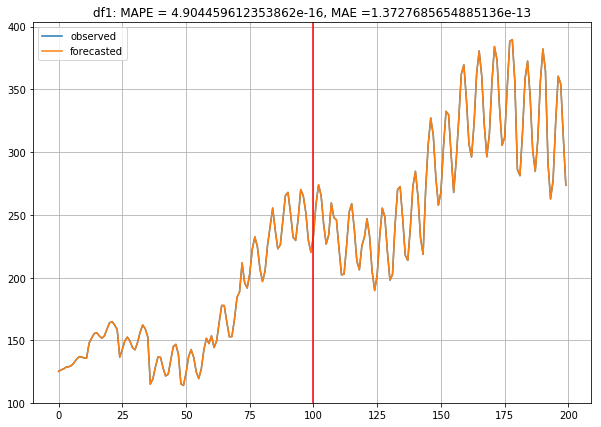

In [15]:
model_1_st_we, in_sample_preds_1_st_we,next_validate_1_st_we = pyramid_stepwise(train_data_1,Exog_train=exog_train,
                                                                                Exog_test=exog_test,
                                                                                  exog_flag=True)
print (model_1_st_we.summary())
plot_results(1,y_1,np.concatenate([in_sample_preds_1_st_we,next_validate_1_st_we]))

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(0, 0, 2)x(1, 0, 0, 12)   Log Likelihood                2943.197
Date:                            Thu, 12 Jul 2018   AIC                          -5866.395
Time:                                    10:52:27   BIC                          -5840.343
Sample:                                         0   HQIC                         -5855.851
                                            - 100                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.663e-14   3.41e-14      0.488      0.626   -5.02e-14    8.35e-14
x1             0.2500   1.18e-15   

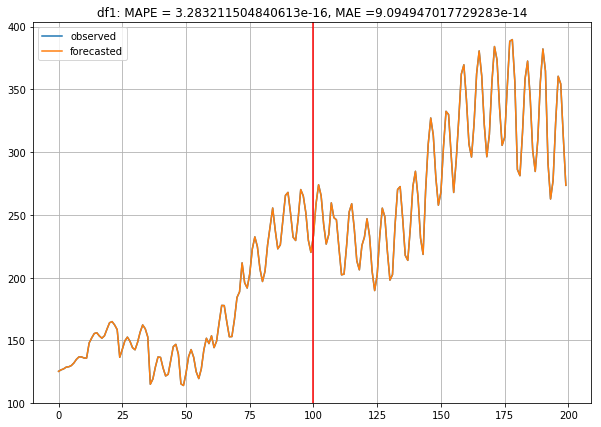

In [16]:
model_1_rs_we, in_sample_preds_1_rs_we,next_validate_1_rs_we = pyramid_random_search(train_data_1,Exog_train=exog_train,
                                                                                     Exog_test=exog_test,
                                                                                      exog_flag=True,n_fits =5000)
print (model_1_rs_we.summary())
plot_results(1,y_1,np.concatenate([in_sample_preds_1_rs_we,next_validate_1_rs_we]))

## Data frame 2

#### without exogenous:

In [17]:
# model_2_st, in_sample_preds_2_st,next_validate_2_st = pyramid_stepwise(train_data_2,Exog_train=exog_train,
#                                                                        Exog_test=exog_test,
#                                                                       exog_flag=False)
# print (model_2_st.summary())
# plot_results(2,y_2,np.concatenate([in_sample_preds_2_st,next_validate_2_st]))

In [18]:
# model_2_rs, in_sample_preds_2_rs,next_validate_2_rs = pyramid_random_search(train_data_2,Exog_train=exog_train,
#                                                                             Exog_test=exog_test,
#                                                                       exog_flag=False,n_fits = 5000)
# print (model_2_rs.summary())
# plot_results(2,y_2,np.concatenate([in_sample_preds_2_rs,next_validate_2_rs]))

##### with exogenous:

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  100
Model:                        SARIMAX   Log Likelihood                -452.148
Date:                Thu, 12 Jul 2018   AIC                            918.296
Time:                        11:26:39   BIC                            936.532
Sample:                             0   HQIC                           925.677
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     66.7544     25.199      2.649      0.008      17.365     116.144
x1             1.3309      0.187      7.119      0.000       0.964       1.697
x2             0.2115      0.105      2.016      0.0

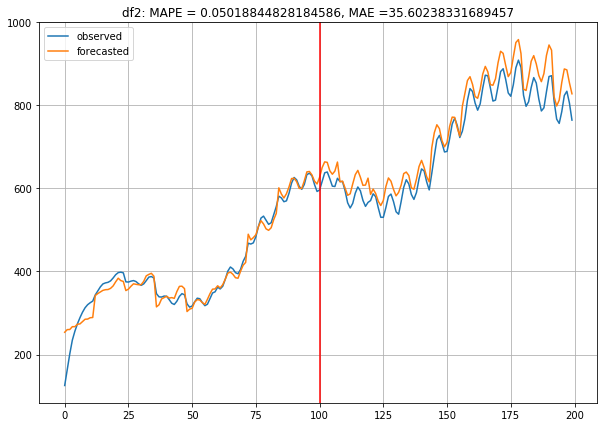

In [13]:
model_2_st_we, in_sample_preds_2_st_we,next_validate_2_st_we = pyramid_stepwise(train_data_2,Exog_train=exog_train,
                                                                                Exog_test=exog_test,
                                                                                  exog_flag=True)
print (model_2_st_we.summary())
plot_results(2,y_2,np.concatenate([in_sample_preds_2_st_we,next_validate_2_st_we]))

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(0, 0, 2)x(1, 0, 0, 12)   Log Likelihood                -390.868
Date:                            Thu, 12 Jul 2018   AIC                            801.736
Time:                                    11:44:57   BIC                            827.787
Sample:                                         0   HQIC                           812.279
                                            - 100                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.5717     14.712      0.175      0.861     -26.264      31.407
x1             2.0162      0.346   

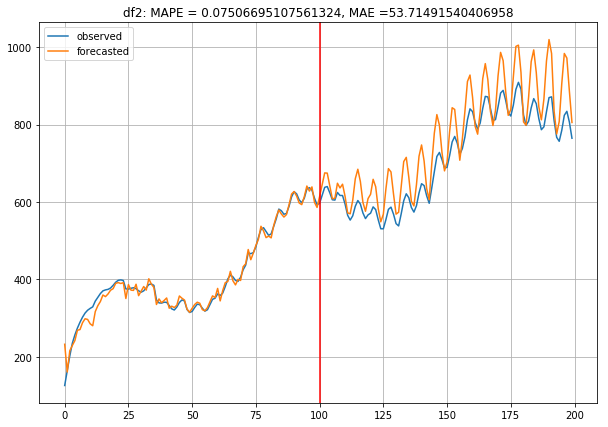

In [14]:
model_2_rs_we, in_sample_preds_2_rs_we,next_validate_2_rs_we = pyramid_random_search(train_data_2,
                                                                    Exog_train=exog_train,Exog_test=exog_test,
                                                                      exog_flag=True,n_fits =5000)
print (model_2_rs_we.summary())
plot_results(2,y_2,np.concatenate([in_sample_preds_2_rs_we,next_validate_2_rs_we]))